In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
#Load the librarys
import pandas as pd #To work with dataset
import numpy as np #Math library
import seaborn as sns #Graph library that use matplot in background
import matplotlib.pyplot as plt #to plot some parameters in seaborn

#Importing the data
df_credit = pd.read_csv("./drive/MyDrive/mlp_i4/german_credit_data.csv",index_col=0)

In [28]:
interval = (18, 25, 35, 60, 120)
cats = ['Student', 'Young', 'Adult', 'Senior']
df_credit["Age_cat"] = pd.cut(df_credit.Age, interval, labels=cats)

In [29]:
df_credit['Saving accounts'] = df_credit['Saving accounts'].fillna('no_inf')
df_credit['Checking account'] = df_credit['Checking account'].fillna('no_inf')

#Purpose to Dummies Variable
df_credit = df_credit.merge(pd.get_dummies(df_credit.Purpose, drop_first=True, prefix='Purpose'), left_index=True, right_index=True)
#Sex feature in dummies
df_credit = df_credit.merge(pd.get_dummies(df_credit.Sex, drop_first=True, prefix='Sex'), left_index=True, right_index=True)
# Housing get dummies
df_credit = df_credit.merge(pd.get_dummies(df_credit.Housing, drop_first=True, prefix='Housing'), left_index=True, right_index=True)
# Housing get Saving Accounts
df_credit = df_credit.merge(pd.get_dummies(df_credit["Saving accounts"], drop_first=True, prefix='Savings'), left_index=True, right_index=True)
# Housing get Risk
df_credit = df_credit.merge(pd.get_dummies(df_credit.Risk, prefix='Risk'), left_index=True, right_index=True)
# Housing get Checking Account
df_credit = df_credit.merge(pd.get_dummies(df_credit["Checking account"], drop_first=True, prefix='Check'), left_index=True, right_index=True)
# Housing get Age categorical
df_credit = df_credit.merge(pd.get_dummies(df_credit["Age_cat"], drop_first=True, prefix='Age_cat'), left_index=True, right_index=True)

In [30]:
del df_credit["Saving accounts"]
del df_credit["Checking account"]
del df_credit["Purpose"]
del df_credit["Sex"]
del df_credit["Housing"]
del df_credit["Age_cat"]
del df_credit["Risk"]
del df_credit['Risk_good']

In [31]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score # to split the data
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score #To evaluate our model

from sklearn.model_selection import GridSearchCV

# Algorithmns models to be compared
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier


In [32]:
df_credit['Credit amount'] = np.log(df_credit['Credit amount'])

In [33]:
#Creating the X and y variables
X = df_credit.drop('Risk_bad', 1).values
y = df_credit["Risk_bad"].values
print(X.shape)
print(y.shape)

# Spliting X and y into train and test version
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

(1000, 24)
(1000,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LR: 0.387574 (0.077970)
LDA: 0.428815 (0.093162)
KNN: 0.263130 (0.035560)
CART: 0.517275 (0.103877)
NB: 0.596300 (0.081365)
RF: 0.366129 (0.098862)
SVM: 0.182230 (0.088462)
XGB: 0.422917 (0.110550)


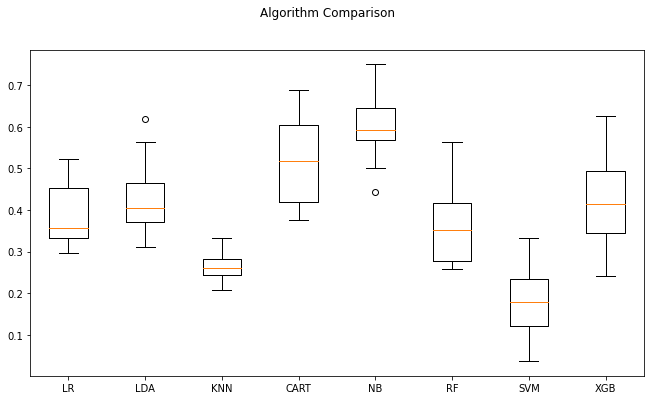

In [34]:
# to feed the random state
seed = None

# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('XGB', XGBClassifier()))

# evaluate each model in turn
results = []
names = []
scoring = 'recall'

for name, model in models:
        kfold = KFold(n_splits=10, random_state=seed)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
# boxplot algorithm comparison
fig = plt.figure(figsize=(11,6))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# **7.1 Model 1 :** <a id="Modelling 1"></a> <br>
- Using Random Forest to predictict the credit score 
- Some of Validation Parameters

In [45]:
#Seting the Hyper Parameters
param_grid = {"max_depth": [3,5, 7, 10,None],
              "n_estimators":[3,5,10,25,50,150],
              "max_features": [4,7,15,20]}

#Creating the classifier
model = RandomForestClassifier(random_state=2)

grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, scoring='recall', verbose=4)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV 1/5] END max_depth=3, max_features=4, n_estimators=3;, score=0.022 total time=   0.0s
[CV 2/5] END max_depth=3, max_features=4, n_estimators=3;, score=0.111 total time=   0.0s
[CV 3/5] END max_depth=3, max_features=4, n_estimators=3;, score=0.065 total time=   0.0s
[CV 4/5] END max_depth=3, max_features=4, n_estimators=3;, score=0.196 total time=   0.0s
[CV 5/5] END max_depth=3, max_features=4, n_estimators=3;, score=0.087 total time=   0.0s
[CV 1/5] END max_depth=3, max_features=4, n_estimators=5;, score=0.044 total time=   0.0s
[CV 2/5] END max_depth=3, max_features=4, n_estimators=5;, score=0.178 total time=   0.0s
[CV 3/5] END max_depth=3, max_features=4, n_estimators=5;, score=0.152 total time=   0.0s
[CV 4/5] END max_depth=3, max_features=4, n_estimators=5;, score=0.174 total time=   0.0s
[CV 5/5] END max_depth=3, max_features=4, n_estimators=5;, score=0.087 total time=   0.0s
[CV 1/5] END max_depth=3, max_feature

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=2),
             param_grid={'max_depth': [3, 5, 7, 10, None],
                         'max_features': [4, 7, 15, 20],
                         'n_estimators': [3, 5, 10, 25, 50, 150]},
             scoring='recall', verbose=4)

In [46]:
print(grid_search.best_score_)
print(grid_search.best_params_)

0.508792270531401
{'max_depth': None, 'max_features': 20, 'n_estimators': 3}


In [47]:
rf = RandomForestClassifier(max_depth=None, max_features=10, n_estimators=15, random_state=2)

#trainning with the best params
rf.fit(X_train, y_train)

RandomForestClassifier(max_features=10, n_estimators=15, random_state=2)

In [48]:
#Testing the model 
#Predicting using our  model
y_pred = rf.predict(X_test)

# Verificaar os resultados obtidos
print(accuracy_score(y_test,y_pred))
print("\n")
print(confusion_matrix(y_test, y_pred))
print("\n")
print(fbeta_score(y_test, y_pred, beta=2))

0.736


[[158  20]
 [ 46  26]]


0.3892215568862275


# **7.2 Model 2:** <a id="Modelling 2"></a> <br>

In [49]:
from sklearn.utils import resample
from sklearn.metrics import roc_curve

In [50]:
# Criando o classificador logreg
GNB = GaussianNB()

# Fitting with train data
model = GNB.fit(X_train, y_train)

In [51]:
# Printing the Training Score
print("Training score data: ")
print(model.score(X_train, y_train))

Training score data: 
0.7053333333333334


In [52]:
y_pred = model.predict(X_test)

print(accuracy_score(y_test,y_pred))
print("\n")
print(confusion_matrix(y_test, y_pred))
print("\n")
print(classification_report(y_test, y_pred))

0.648


[[124  54]
 [ 34  38]]


              precision    recall  f1-score   support

           0       0.78      0.70      0.74       178
           1       0.41      0.53      0.46        72

    accuracy                           0.65       250
   macro avg       0.60      0.61      0.60       250
weighted avg       0.68      0.65      0.66       250



0.7029494382022472


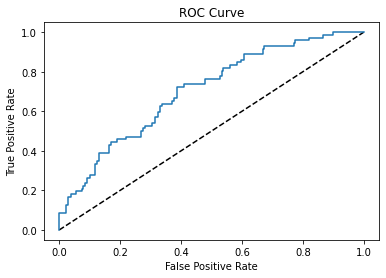

In [58]:
from sklearn.metrics import roc_auc_score
#Predicting proba
y_pred_prob = model.predict_proba(X_test)[:,1]
print(roc_auc_score(y_test, y_pred_prob))
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()